# Anatomy of PPLs

**Frequentist**

Probabilities make sense only if there is some repeating event.
Probability over parameters don't make sense since there is only one true parameter.
Learning is the task of searching for this one true parameter

**Bayesian**

Probabilities are about uncertainty.
We are uncertain about the parameters of our model since models are approximations.


**Why Bayesian Modeling?**

- Small data
- Model uncertainty
- Transparency/Interpretability
- No more loss hacking
- Easy to impose constraining knowledge (as priors)
- Easy to combine information from different types of sensors

**Uncertainty**

There is uncertainty inherent in data due to incompleteness and measurement noise. This uncertainty propogates to the model. Unless we explicitly account for this uncertainty in the model, we have no means of measuring and managing it.

**Model**

Models are an approximation of a real world phenomenon. Models are built based on our knowledge of the data generating process. Data-driven models combine expert insight with observed data. 

Human insight constraints the space of models within which the best model is "found" through optimization methods.



**Probabilistic Model**

A frequentist model (think Linear Regression $y=wx +b$) is a (deterministic) mapping from features to output. 

- Features : $x = [x_1, x_2, .. x_n]$ 
- Model : $y = wx + b$
- Output : $y\ \epsilon\ (-\inf, +\inf)$

A probabilistic model represent a joint probability of observed and latent variables (factors).
Variables are probability distributions.

- Observed Variable : x
- Model : (Joint Distribution) $p(x, y)$
    - Latent Variable : $w \sim \mathcal{N}(w_{loc}, w_{scale})$
    - Latent Variable : $b \sim \mathcal{N}(b_{loc}, b_{scale})$
    - $y \sim \mathcal{N}(wx + b)$
- Outcome Variable : y
    - Observed Variable during Inference
        - $p(w | x = ..., y = ... )$
        - $p(b | x = ..., y = ... )$
    

**Probabilistic Programming**

- Python Constructs (if, while, ...)
    - Recursion
    - Higher order Functions
- Randomness
    - Distributions
         - Normal
         - Bernoulli

**Distributions**

A distribution must have these 3 methods:

- sample
- score
- support


**Normal**

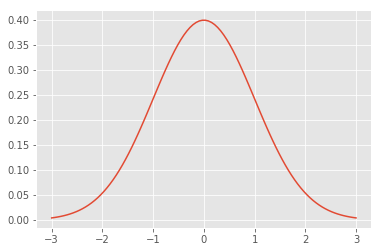

In [4]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
x = np.linspace(-3., 3., 100)
plt.plot(x, stats.norm.pdf(x, 0., 1.))

In [17]:
import torch.distributions as tdist
d = tdist.Normal(0., 1.)
d.sample(), d.support, d.log_prob(0.5), d.log_prob(-0.5)

(tensor(-1.1386), Real(), tensor(-1.0439), tensor(-1.0439))

**Bernoulli**

In [29]:
d = tdist.Bernoulli(0.5)
d.sample(), d.support

(tensor(1.), Boolean())

**How to encode a model in python?**

We would like to write the joint probability $p(x, z)$ as a function.

```python
def model(x, y):
    w = sample('w', Normal(0., 1.))
    b = sample('b', Normal(0., 1.))
    y_mean = w*x + b
    y_sample = sample('y', Normal(y_mean, 1.))
    return y_sample
```

**How to learn from data?**

To learn from data, we need to track the variables of interest. In this case, `w` and `b` are our latent variables which should be inferred from the data. `y` is the observed variable during inference. How do we track these variables (name and corresponding distribution function). 

**Tracking Variables**

Notice that every variable of interest is associated with a `sample` call. To track the variables, we make the `sample` call "effectful". In addition to just returning a sample from the distribution, `sample` call adds the "sample site" to a global registry.

**Enter the Stack**

In [1]:
STACK = []

**Learning Variables**

You should have noticed that the variables are *parametric* probability distributions ($w \sim N(0., 1.)$). Learning variables means learning the parameters of these distributions.

Know the difference between *latent variables* and *parameters*.

![](https://i.imgur.com/1CyonQG.png)

$$p(x,z) = p(x)p(z|x) = p(x|z)p(z)$$
$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$
$$p(z|x) = \frac{p(x,z)}{\int p(x,z)\ dz}$$

Learning the posterior $p(z|x)$ analytically is impossible (or just insanely hard). 

**Omg! What now?**

We introduce a new parametric distribution $q_{\phi}(z)$, parameterized by $\phi$ (variational parameters). Pyro developers chose to call this a *guide* in the context of pyro.

The idea is to consider $q$ as an approximation to the true posterior $p(z\ |\ x)$ and optimize it to be as close as possible to the posterior, while maintaining the simplicity of $q$.

![](https://i.imgur.com/5HGBpcb.png)

**Mean-Field Assumption**

$q$ is typically chosen as a factorizable distribution

$$q(z) = q(z_1)q(z_2)...q(z_m)$$

**Exponential Family**

$$q(z) = \mathcal{N}(loc_{z_1}, scale_{z_1})\mathcal{N}(loc_{z_2}, scale_{z_2})...\mathcal{N}(loc_{z_m}, scale_{z_m})$$

**Note** : Latent variables get the bayesian treatment; (Variational) Parameters don't.

**Encode guide as a function**

```python
def guide(x, y):
  """ Variational Parameters """
  w_loc = param('w_loc', 0.)
  w_scale = param('w_scale', 1.)  # +ve
  b_loc = param('b_loc', 0.)
  b_scale = param('b_scale', 1.)  # +ve

  """ Latent Variables """
  w = sample('w', Normal(w_loc, w_scale))
  b = sample('b', Normal(b_loc, b_scale))
```

**`param` calls are effectful**

The `param` function stores the parameters with names to the `PARAM_STORE`



In [32]:
PARAM_STORE = {}

**Inference**

We have turned inference to an optimization problem. But what is the objective function? We need our approximation to be as close as possible to the intractable posterior. Although we do not 

![](https://i.imgur.com/XgbxrhO.png)


$$L = \int_z q(z)\ log\frac{p(x, z)}{q(z)}$$

When you see an intractable integral, you think *Monte Carlo Approximation*.

$$L = \mathbb{E}_{q_{\phi}(z)}\ \big{[}log\ p_{\theta}(x,z) - log\ q_{\phi}(z)\big{]}$$

- $log\ p_{\theta}(x, z)$
    - Log Probability of sample $z \sim q(z)$ evaluated under model $p(x,z)$
    - We add up individual log probabilites of $z_1, z_2, .. z_m$
        - Because, *Mean-field assumption* baby!
    - $\{w, b\}$ in our case
- $log\ q_(z)$
    - Log probability of sample $z \sim q(z)$ evaluated under guide $q(z)$

![](https://www2.isye.gatech.edu/~brani/isyebayes/bank/bayesfun.jpg)

**Implementing Inference**

Remember the registry? I lied. It's not exactly a registry. The `sample` statements are encoded as messages and sent to a bunch of listeners or handlers that will make use of the messages.

**Message Encoding**

```python
msg = {
    'name' : 'w',
    'type' : 'sample',  # there are other types? yeah.. hang in there!
    'fn'   : Normal(0., 1.),
    'stop' : False  # a handler decides to set this, so other handlers don't   touch this msg
}
```

The `param` function also creates a message (of type `param`) and sends it to thhe handlers.

**Handlers**

The handlers deal with the messages (sample sites). Types of handlers : 

- Trace : Just take a copy of all the messages
- Block : If a condition succeeds, set `'stop' = False`
- Replay
    - Run a model by reusing samples from guide
    - Implemented to support Monte-Carlo ELBO
    - Calculate log probability density of samples from guide $q(z)$ under the model $p(x,z)$
    
Handlers are designed to support inference. There will be multiple handlers at work at the same time, as we will see later. The handlers are put in a stack. The messages are passed through the stack.

**ELBO Implementation**

```python
def elbo(model, guide, *args, **kwargs):
    # run guide with args
    # record `sample` and `param` calls
    guide_trace = trace(guide).get_trace(*args, **kwargs)
    # trace model execution
    # replay : reuse sampled values from guide trace
    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)
    # elbo
    elbo = 0.
    # iterate through sample sites in model
    # add log_p(z) term to ELBO
    for site in model_trace.values():
        if site['type'] == 'sample':
            elbo = elbo + site['fn'].log_prob(site['value']).sum()
    # iterate through sample sites in guide
    # add log_q(z) term to ELBO
    for site in guide_trace.values():
        if site['type'] == 'sample':
            elbo = elbo - site['fn'].log_prob(site['value']).sum()
    return -elbo  # because we minimize
```

**Stochastic Variational Inference**

```python
class SVI(object):
  # Interface for Stochastic Variational Inference
  # [ model, guide, optimizer, loss_fn ]
  #
  # [1] Run Model and Guide
  # [2] Construct loss function
  # [3] Take a gradient step
  def __init__(self, model, guide, optimizer, loss_fn):
    self.model = model
    self.guide = guide
    self.optimizer = optimizer
    self.loss_fn = loss_fn

  def step(self, *args, **kwargs):
    # run trace to capture parameter values
    with trace() as param_capture:
      # block `sample` sites from trace; capture only parameters
      with block(hide_fn=lambda msg : msg['type'] == 'sample'):
        # calculate loss
        loss = self.loss_fn(self.model, self.guide, *args, **kwargs)
        
    # calculate gradients
    loss.backward()
    # grab parameters from trace
    params = [ site['value'].unconstrained()
        for site in param_capture.values() ]
    # run optimizer; update params
    self.optimizer(params)
    for p in params:  # clear gradients
      p.grad = p.new_zeros(p.shape)
    return loss.item()
```

# Latent Normal

In [41]:
import minipyro.minipyro as pyro
import torch

from torch.distributions import constraints
import pyro.distributions as pdist

import examples.plots as plots
from tqdm import tqdm

True model : Normal(3., 1.)
[0] loss : 414.2901306152344
[100] loss : 399.85675048828125
[200] loss : 191.5714569091797
[300] loss : 186.42105102539062
[400] loss : 154.4515838623047
[500] loss : 150.4410858154297
[600] loss : 178.04165649414062
[700] loss : 156.76803588867188
[800] loss : 156.51998901367188
[900] loss : 153.68597412109375
[1000] loss : 153.26736450195312
[1100] loss : 150.77259826660156
[1200] loss : 152.75244140625
[1300] loss : 150.82701110839844
[1400] loss : 152.2942352294922
[1500] loss : 152.25413513183594
[1600] loss : 152.9546661376953
[1700] loss : 151.0872039794922
[1800] loss : 151.2337646484375
[1900] loss : 151.1259002685547
[2000] loss : 152.5985870361328
[2100] loss : 151.6265106201172
[2200] loss : 152.07591247558594
[2300] loss : 153.12367248535156
[2400] loss : 151.27267456054688
[2500] loss : 151.3333740234375
[2600] loss : 151.6221923828125
[2700] loss : 151.5823516845703
[2800] loss : 151.34034729003906
[2900] loss : 151.36680603027344
[3000] loss

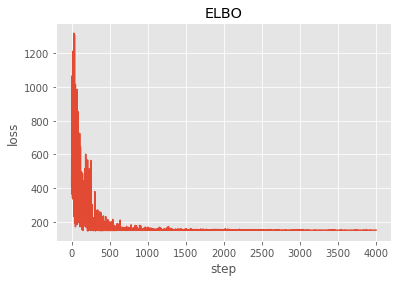

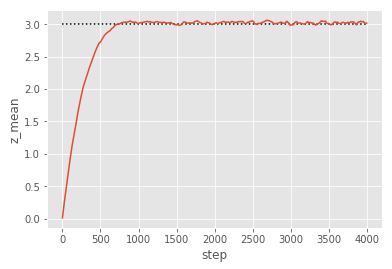

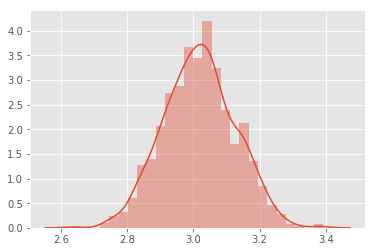

In [40]:
def generate_data():
  return torch.randn(100) + 3


if __name__ == '__main__':
  # generate data
  data = generate_data()
  # true model
  print('True model : Normal(3., 1.)')

  def model(data):
    z_loc = pyro.sample('z_loc', pdist.Normal(0., 1.))
    # normally distributed observations
    # for datapoint in data:
    pyro.sample('obs', pdist.Normal(z_loc, 1.), obs=data)
    # break

  def guide(data):
    # define parameters
    #  loc and scale for latent variable `z_loc`
    guide_loc = pyro.param('guide_loc', torch.tensor(0.))
    guide_scale = pyro.param('guide_scale', torch.tensor(1.),
        constraint=constraints.positive
        )
    # we would like to learn the distribution `loc`
    pyro.sample('z_loc', pdist.Normal(guide_loc, guide_scale))

  # clear parameter store
  pyro.PARAM_STORE.clear()

  # learning rate
  lr = 0.01
  # training steps
  num_steps = 4000

  # SVI for inference
  svi = pyro.SVI(model, guide, optimizer=pyro.Adam({'lr' : lr}), loss_fn=pyro.elbo)

  losses, z = [], []
  for step in range(num_steps):
    loss = svi.step(data)
    losses.append(loss)
    z.append(pyro.param('guide_loc').item())
    if step % 100 == 0:
      print('[{}] loss : {}'.format(step, loss))

  print('LOC : ', pyro.param('guide_loc'))
  print('SCALE : ', pyro.param('guide_scale'))

  plots.elbo(losses)
  plots.param(z, 3., name='z_mean')
  plots.density_plot(
      plots.sample_normal(
        pyro.param('guide_loc').item(),
        pyro.param('guide_scale').item(),
        N=1000
        )
      )

# Linear Regression

  1%|          | 38/5000 [00:00<00:13, 371.18it/s]

TRUE DISTRIBUTION : 2.0x + 1.0
len(trainset) :  2


100%|██████████| 5000/5000 [00:11<00:00, 435.46it/s]


W(LOC) :  1.9820785522460938 0.132353737950325
b(LOC) :  1.0160022974014282 0.06630779802799225


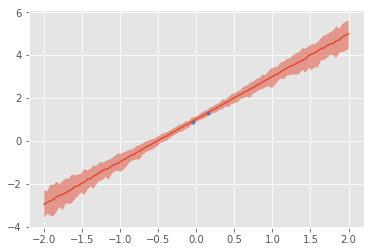

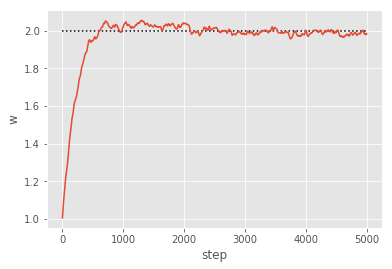

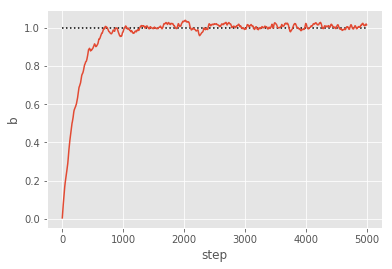

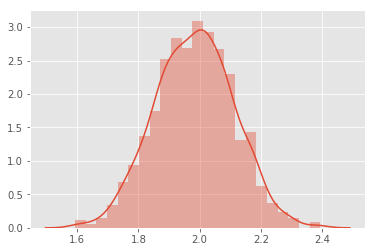

In [45]:
def random_sample(t, k):
  x, y = t
  indices = torch.randperm(len(x))
  return x[indices][:k], y[indices][:k]


def noisy():
  x = torch.arange(-0.05, 0.2, 0.1)
  w, b = 2., 1.
  y = w * x + b + torch.normal(torch.tensor(0.), torch.tensor(0.01))
  print('TRUE DISTRIBUTION : {w}x + {b}'.format(w=w, b=b))
  x, y = random_sample((x, y), len(x))
  k = int(len(x) * 0.8)

  return (x[:k], y[:k]), (x[k:], y[k:])


def model(x, y):
  w = pyro.sample('w', pdist.Normal(0., 1.))
  b = pyro.sample('b', pdist.Normal(0.5, 1.))
  # define model
  mean = w * x + b
  # variance of distribution centered around y
  # sigma = pyro.sample('sigma', pdist.Normal(0., 0.01))
  pyro.sample('obs', pdist.Normal(mean, 0.01), obs=y)
  return mean


def guide(x, y):
  # parameters of (w : weight)
  w_loc = pyro.param('w_loc', torch.tensor(1.))
  w_scale = pyro.param('w_scale', torch.tensor(1.),
      constraint=constraints.positive
      )
  # parameters of (b : bias)
  b_loc = pyro.param('b_loc', torch.tensor(0.))
  b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=constraints.positive)
  # parameters of (sigma)
  # sigma_loc = pyro.param('sigma_loc', torch.tensor(0.), constraint=constraints.positive)  # .exp()

  # sample (w, b, sigma)
  w = pyro.sample('w', pdist.Normal(w_loc, w_scale))
  b = pyro.sample('b', pdist.Normal(b_loc, b_scale))
  # sigma = pyro.sample('sigma', pdist.Normal(sigma_loc, torch.tensor(0.05)))


def prob_forward(x):
  w = tdist.Normal(pyro.param('w_loc'), pyro.param('w_scale'))
  b = tdist.Normal(pyro.param('b_loc'), pyro.param('b_scale'))
  return w.sample(x.size()) * x + b.sample(x.size())


def sample_from_posterior(x, fwd, n=100):
  return np.array([ fwd(x).detach().numpy().reshape(-1) for _ in range(n) ])


if __name__ == '__main__':
  # generate data
  (train_x, train_y), (test_x, test_y) = noisy()
  # num of data points
  print('len(trainset) : ', len(train_x))

  # clear parameter store
  pyro.PARAM_STORE.clear()

  # learning rate
  lr = 0.005
  # training steps
  num_steps = 5000

  # SVI for inference
  svi = pyro.SVI(model, guide, optimizer=pyro.Adam({'lr' : lr}), loss_fn=pyro.elbo)

  losses, w, b = [], [], []
  for step in tqdm(range(num_steps)):
    loss = svi.step(train_x, train_y)
    # if step % 100 == 0:
    losses.append(loss)
    w.append(pyro.param('w_loc').item())
    b.append(pyro.param('b_loc').item())

    # if step % 100 == 0:
    # print('[{}] loss : {}'.format(step, loss))

  print('W(LOC) : ', pyro.param('w_loc').item(), pyro.param('w_scale').item())
  print('b(LOC) : ', pyro.param('b_loc').item(), pyro.param('b_scale').item())

  x_pred = torch.linspace(-2, 2, 100).reshape(-1, 1)
  plots.posterior_predictive((train_x, train_y), x_pred,
      sample_from_posterior(x_pred, prob_forward)
      )

  plots.param(w, 2., name='w')
  plots.param(b, 1., name='b')
  plots.density_plot(
      plots.sample_normal(
        pyro.param('w_loc').item(),
        pyro.param('w_scale').item(),
        N=1000
        )
      )

# Bayesian Neural Network

  0%|          | 23/5000 [00:00<00:22, 217.40it/s]

len(trainset) :  6
tensor([[0.0000],
        [0.2000],
        [0.4000],
        [0.6000],
        [0.8000],
        [1.0000]]) tensor([[3.2000],
        [3.4400],
        [3.7600],
        [4.1600],
        [4.6400],
        [5.2000]])


100%|██████████| 5000/5000 [00:20<00:00, 246.97it/s]


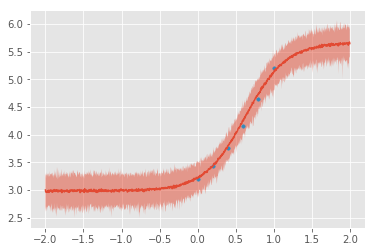

In [44]:
def toy_parabolic_fn(x):
    return x**2 + x + 3.2


def toy_parabolic_data(n):  # TODO : use `n`
  # x = torch.tensor([-2, -1.8, -1, 1, 1.8, 2]).reshape(-1, 1)
  # x = torch.arange(0., 1., 0.2).reshape(-1, 1)
  x = torch.tensor([0., 0.2, 0.4, 0.6, 0.8, 1.]).reshape(-1, 1)
  y = toy_parabolic_fn(x)
  return x, y


def model(x, y):
  w1 = pyro.sample('w1', pdist.Normal(0., 1.))
  b1 = pyro.sample('b1', pdist.Normal(0., 1.))
  w2 = pyro.sample('w2', pdist.Normal(0., 1.))
  b2 = pyro.sample('b2', pdist.Normal(0., 1.))
  # define model
  mean = w2 * torch.tanh(w1 * x + b1) + b2
  pyro.sample('obs', pdist.Normal(mean, 0.01), obs=y)
  return mean


def guide(x, y):
  # parameters of (w : weight)
  w_loc_1 = pyro.param('w_loc_1', torch.tensor(0.))
  w_scale_1 = pyro.param('w_scale_1', torch.tensor(1.),
      constraint=constraints.positive
      )
  # parameters of (b : bias)
  b_loc_1 = pyro.param('b_loc_1', torch.tensor(0.))
  b_scale_1 = pyro.param('b_scale_1', torch.tensor(1.), constraint=constraints.positive)

  w_loc_2 = pyro.param('w_loc_2', torch.tensor(0.))
  w_scale_2 = pyro.param('w_scale_2', torch.tensor(1.),
      constraint=constraints.positive
      )
  b_loc_2 = pyro.param('b_loc_2', torch.tensor(0.))
  b_scale_2 = pyro.param('b_scale_2', torch.tensor(1.), constraint=constraints.positive)

  w1 = pyro.sample('w1', pdist.Normal(w_loc_1, w_scale_1))
  b1 = pyro.sample('b1', pdist.Normal(b_loc_1, b_scale_1))
  w2 = pyro.sample('w2', pdist.Normal(w_loc_2, w_scale_2))
  b2 = pyro.sample('b2', pdist.Normal(b_loc_2, b_scale_2))


def prob_forward(x):
  w1 = tdist.Normal(pyro.param('w_loc_1'), pyro.param('w_scale_1'))
  b1 = tdist.Normal(pyro.param('b_loc_1'), pyro.param('b_scale_1'))
  w2 = tdist.Normal(pyro.param('w_loc_2'), pyro.param('w_scale_2'))
  b2 = tdist.Normal(pyro.param('b_loc_2'), pyro.param('b_scale_2'))
  h1 = torch.tanh(w1.sample(x.size()) * x + b1.sample(x.size()))
  return w2.sample(h1.size()) * h1 + b2.sample(h1.size())


def sample_from_posterior(x, fwd, n=100):
  return np.array([ fwd(x).detach().numpy().reshape(-1) for _ in range(n) ])


if __name__ == '__main__':
  # generate data
  x, y = toy_parabolic_data(10)
  # num of data points
  print('len(trainset) : ', len(x))
  print(x, y)

  # clear parameter store
  pyro.PARAM_STORE.clear()

  # learning rate
  lr = 0.008
  # training steps
  num_steps = 5000

  # SVI for inference
  svi = pyro.SVI(model, guide, optimizer=pyro.Adam({'lr' : lr}), loss_fn=pyro.elbo)

  losses, w, b = [], [], []
  for step in tqdm(range(num_steps)):
    loss = svi.step(x, y)
    losses.append(loss)

    # if step % 100 == 0:
    # print('[{}] loss : {}'.format(step, loss))

  x_pred = torch.linspace(-2, 2, 1000).reshape(-1, 1)
  plots.posterior_predictive((x, y), x_pred,
      sample_from_posterior(x_pred, prob_forward)
      )

# Logistic Regression

In [56]:
def iris(datafile='examples/iris.data'):
  # label to index lookup
  # label2idx = { 'Iris-setosa' : 0, 'Iris-versicolor' : 1, 'Iris-virginica' : 2 }
  label2idx = { 'Iris-setosa' : 0, 'Iris-versicolor' : 1 }
  lines = [ l.replace('\n', '').strip() for l in open(datafile).readlines() ]
  # shuffle lines
  shuffle(lines)
  features, labels = [], []
  for line in lines:
    # super-annoying empty last line
    if not line:
      break

    items = line.split(',')
    label = items[-1]

    # check if label is in label2idx
    if label not in label2idx:
      continue

    features.append([ float(i) for i in items[:-1] ])
    labels.append(label2idx[label])

  # train/test separation
  k = int(0.8 * len(features))
  train_x, train_y = features[:k], labels[:k]
  test_x, test_y = features[k:], labels[k:]
  # convenience
  t = torch.tensor

  return (
      ( t(train_x), t(train_y).float() ),
      ( t(test_x), t(test_y).float() )
      )


def model(x, y):
  w = pyro.sample('w', pdist.Normal(torch.zeros(4), torch.ones(4)))
  b = pyro.sample('b', pdist.Normal(0., 1.))

  # define logistic regression model
  y_hat = torch.sigmoid((w * x).sum(dim=1) + b)

  # variance of distribution centered around y
  # sigma = pyro.sample('sigma', pdist.Normal(0., 0.01))

  pyro.sample('obs', pdist.Bernoulli(y_hat), obs=y)


def guide(x, y):
  # parameters of (w : weight)
  w_loc = pyro.param('w_loc', torch.zeros(4))
  w_scale = pyro.param('w_scale', torch.ones(4),
      constraint=constraints.positive
      )
  # parameters of (b : bias)
  b_loc = pyro.param('b_loc', torch.tensor(0.))
  b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=constraints.positive)

  w = pyro.sample('w', pdist.Normal(w_loc, w_scale))
  b = pyro.sample('b', pdist.Normal(b_loc, b_scale))


def prob_forward(x):
  w = tdist.Normal(pyro.param('w_loc'), pyro.param('w_scale'))
  b = tdist.Normal(pyro.param('b_loc'), pyro.param('b_scale'))
  return torch.sigmoid((w.sample([1]) * x).sum() + b.sample([1]))


def sample_from_posterior(x, fwd, n=100):
  return np.array([ fwd(x).detach().numpy().reshape(-1) for _ in range(n) ])


if __name__ == '__main__':
  # generate data
  (train_x, train_y), (test_x, test_y) = iris()

  # clear parameter store
  pyro.PARAM_STORE.clear()

  # learning rate
  lr = 0.005
  # training steps
  num_steps = 2000

  # SVI for inference
  svi = pyro.SVI(model, guide, optimizer=pyro.Adam({'lr' : lr}), loss_fn=pyro.elbo)

  losses, w, b = [], [], []
  for step in tqdm(range(num_steps)):
    loss = svi.step(train_x, train_y)
    # if step % 100 == 0:
    losses.append(loss)
    w.append(pyro.param('w_loc').data.numpy())
    b.append(pyro.param('b_loc').item())

    # if step % 100 == 0:
    # print('[{}] loss : {}'.format(step, loss))

  w_ps = pyro.param('w_loc')
  b_ps = pyro.param('b_loc')

  print('w : {}; b : {}'.format(w_ps, b_ps))

  def predict(x):
    x = torch.tensor(x)
    return torch.sigmoid((w_ps * x).sum() + b_ps)

  correcto = 0
  for xi, yi in zip(test_x, test_y):
    num_samples = 1000
    samples = sample_from_posterior(torch.tensor(xi).view(1, -1),
        prob_forward, num_samples)
    correcto = (((samples > 0.5) == yi.item()).sum())
    print('[{}] {}/{} with {}% certainty'.format(yi, correcto, num_samples,
      100. * correcto / num_samples))

100%|██████████| 2000/2000 [00:05<00:00, 399.81it/s]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


w : tensor([-0.2985, -1.1911,  1.7610,  1.8509], requires_grad=True); b : -0.4941481053829193
[1.0] 995/1000 with 99.5% certainty
[0.0] 981/1000 with 98.1% certainty
[1.0] 989/1000 with 98.9% certainty
[0.0] 993/1000 with 99.3% certainty
[1.0] 999/1000 with 99.9% certainty
[0.0] 997/1000 with 99.7% certainty
[1.0] 996/1000 with 99.6% certainty
[1.0] 997/1000 with 99.7% certainty
[0.0] 932/1000 with 93.2% certainty
[0.0] 996/1000 with 99.6% certainty
[0.0] 982/1000 with 98.2% certainty
[1.0] 994/1000 with 99.4% certainty
[1.0] 999/1000 with 99.9% certainty
[1.0] 993/1000 with 99.3% certainty
